In [1]:
import os
import pandas as pd
import numpy as np
import torch as tc
import torch.nn as nn
from tqdm import tqdm
import time
import json
import itertools
import matplotlib.pyplot as plt

# --- Importe suas classes ---
# (Assumindo que estão no PYTHONPATH ou na mesma pasta)
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import HybridCQN 
from method.qnn import QuantumNeuralNetwork
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tc
import torch.nn as nn
import numpy as np
import json

# --- Importe suas classes ---
# (Precisamos delas para RECONSTRUIR a arquitetura antes de carregar os pesos)
from equation.option_pricing import BlackScholes
from method.nn import MLP, ResNet
from method.hnn import HybridCQN
from method.qnn import QuantumNeuralNetwork
from utils.save import *



2025-11-12 09:39:12.423698: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 09:39:12.456768: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-12 09:39:13.189483: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# =============================================================================
# 0. CONFIGURAÇÃO
# =============================================================================

# Métrica principal para avaliar os modelos (use a desnormalizada)
MSE_COLUMN = 'mse_teste_desnormalizado'
LOSS_COLUMN = 'mean_last_100_loss' # ou 'mean_last_100_loss'

# Constantes de normalização (as mesmas usadas no treino)
S_max = 160.0
T = 1.0
V_max = 140.0

In [6]:
# =============================================================================
# 1. CARREGAR OS DADOS DO SUMÁRIO
# =============================================================================

all_dfs = []

try:
    df_classic = pd.read_csv(SUMMARY_CLASSIC_PATH)
    all_dfs.append(df_classic)
    print(f"Carregado {len(df_classic)} runs de '{SUMMARY_CLASSIC_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CLASSIC_PATH}' não encontrado. Pulando.")

try:
    df_hybrid = pd.read_csv(SUMMARY_HYBRID_PATH)
    all_dfs.append(df_hybrid)
    print(f"Carregado {len(df_hybrid)} runs de '{SUMMARY_HYBRID_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_HYBRID_PATH}' não encontrado. Pulando.")

try:
    df_quantum = pd.read_csv(SUMMARY_QUANTUM_PATH)
    all_dfs.append(df_quantum)
    print(f"Carregado {len(df_quantum)} runs de '{SUMMARY_QUANTUM_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_QUANTUM_PATH}' não encontrado. Pulando.")

try:
    df_quantum = pd.read_csv(SUMMARY_CQUANTUM_PATH)
    all_dfs.append(df_quantum)
    print(f"Carregado {len(df_quantum)} runs de '{SUMMARY_CQUANTUM_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CQUANTUM_PATH}' não encontrado. Pulando.")
try:
    df_chybrid = pd.read_csv(SUMMARY_CHYBRID_PATH)
    all_dfs.append(df_chybrid)
    print(f"Carregado {len(df_chybrid)} runs de '{SUMMARY_CHYBRID_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CHYBRID_PATH}' não encontrado. Pulando.")



if not all_dfs:
    print("ERRO: Nenhum arquivo de sumário encontrado. Rode 'run_experiments.py' primeiro.")
    exit()

# Concatena todos os dataframes para análise comparativa
df_all = pd.concat(all_dfs, ignore_index=True)

Carregado 210 runs de 'experimentos_pinn/sumario_classico.csv'
Carregado 1 runs de 'experimentos_pinn/sumario_hibrido.csv'
Carregado 85 runs de 'experimentos_pinn/sumario_quantico.csv'
Carregado 158 runs de 'experimentos_pinn/sumario_cquantico.csv'
Carregado 169 runs de 'experimentos_pinn/sumario_chibrido.csv'


Gerando plots estatísticos...


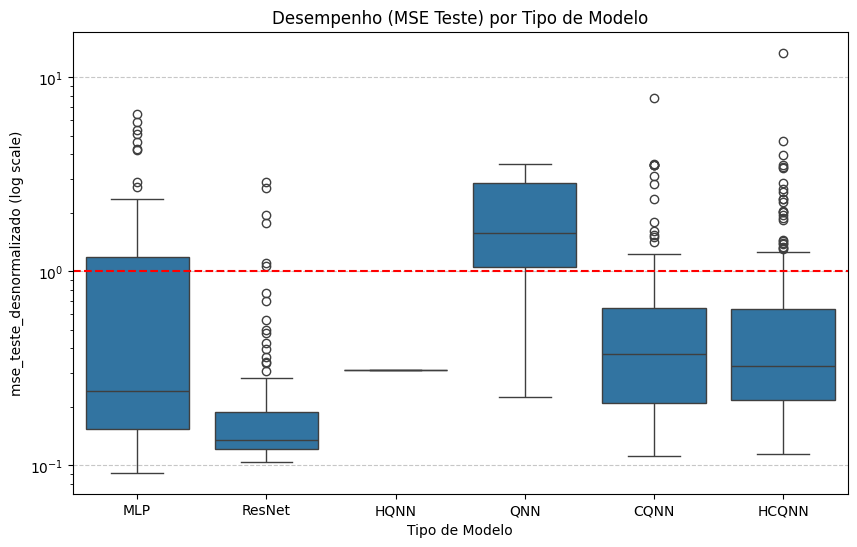

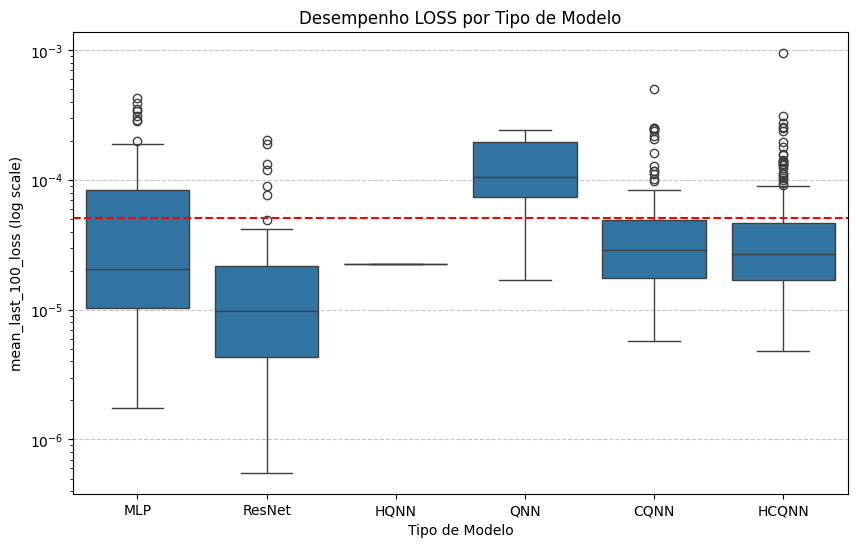

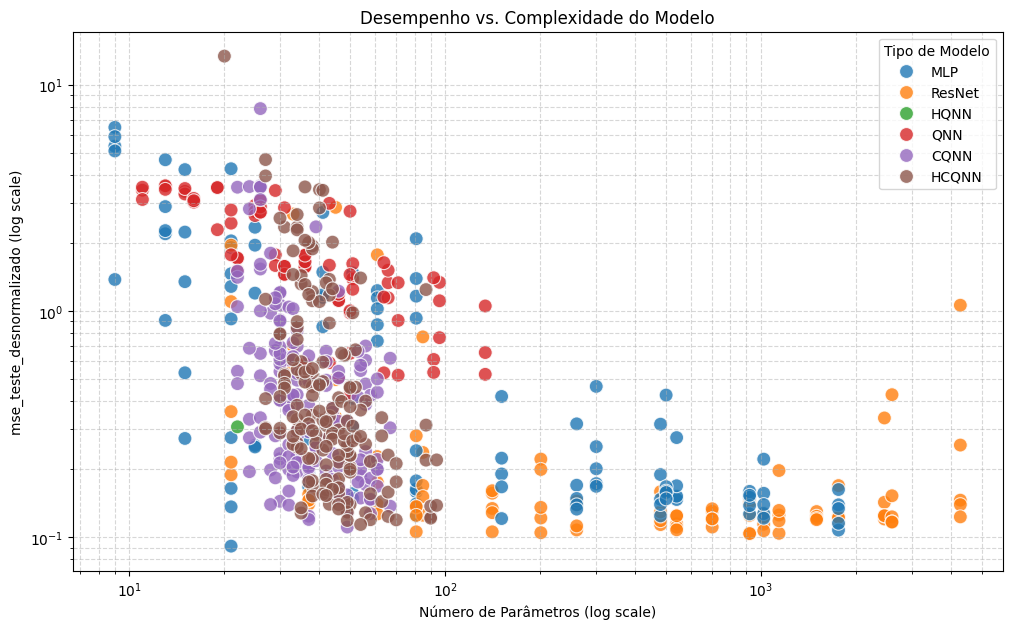

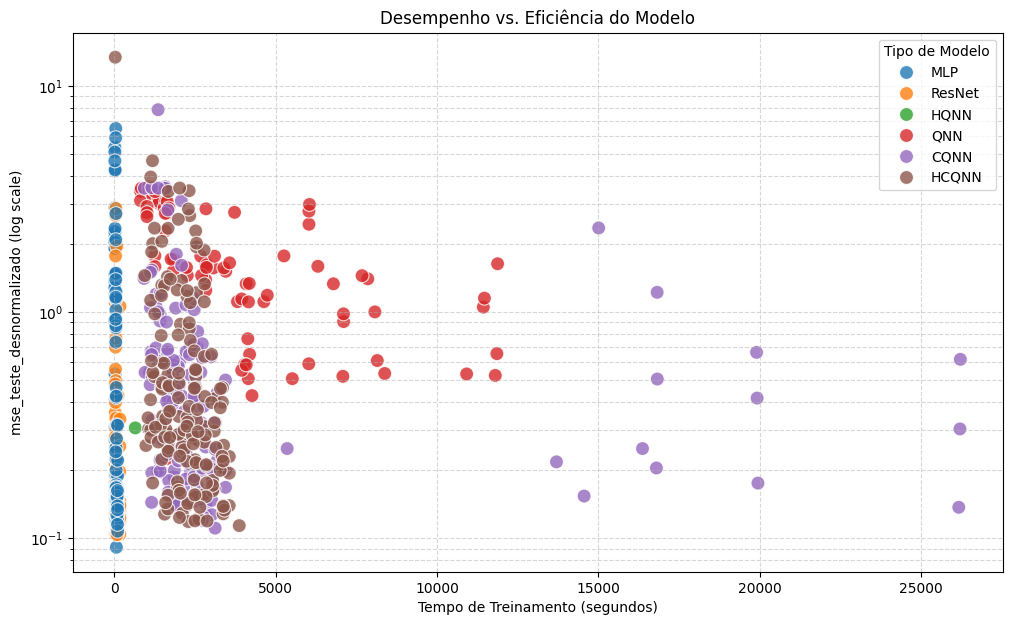

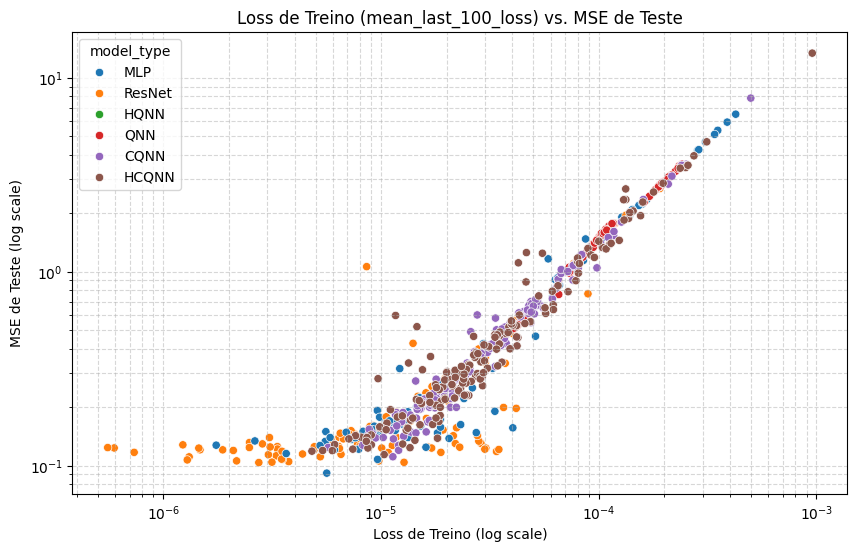

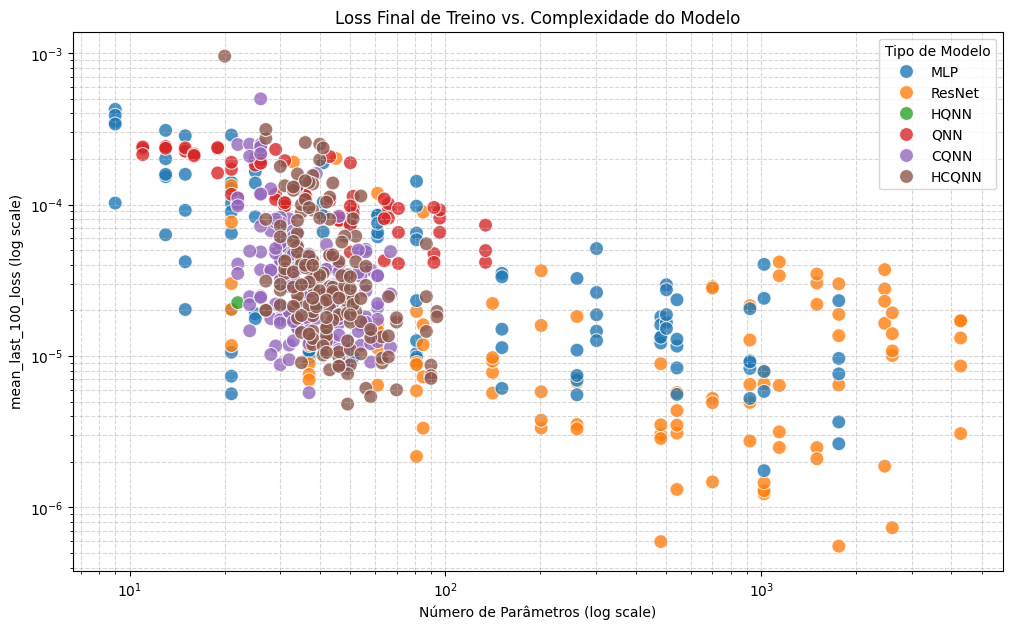

Gerando plots de impacto da arquitetura...


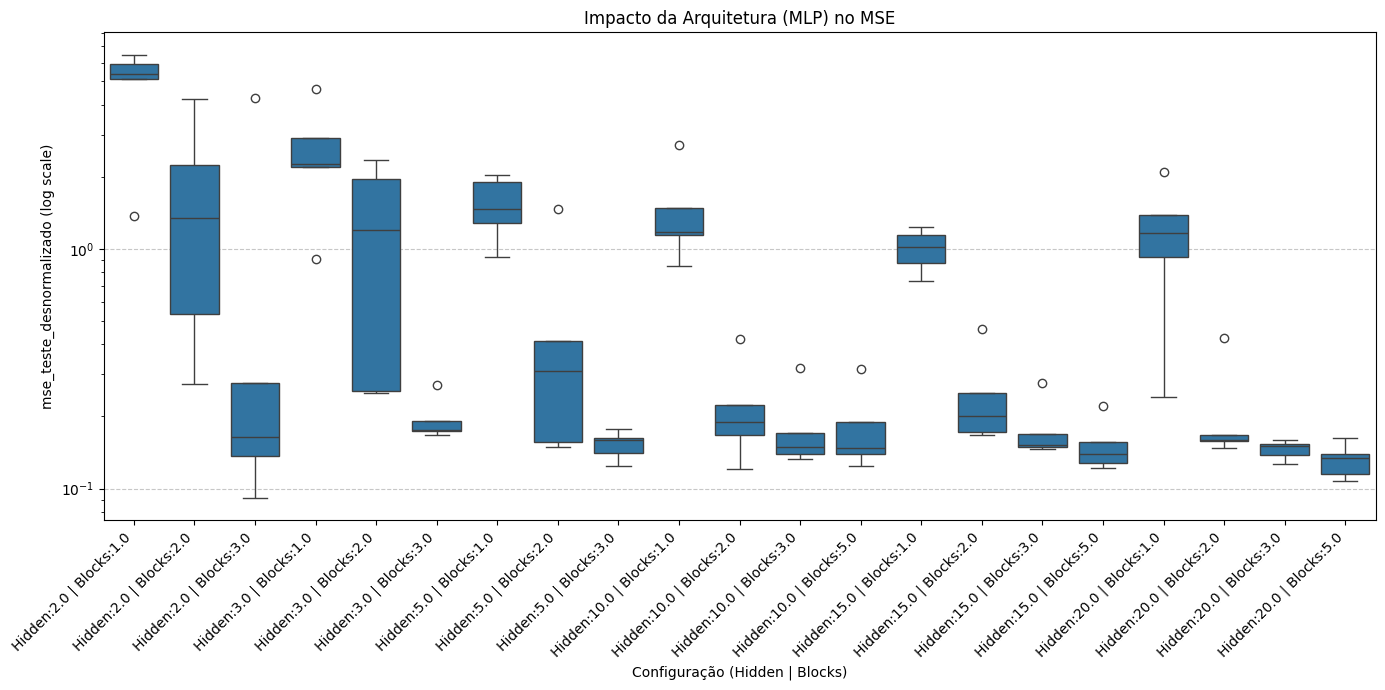

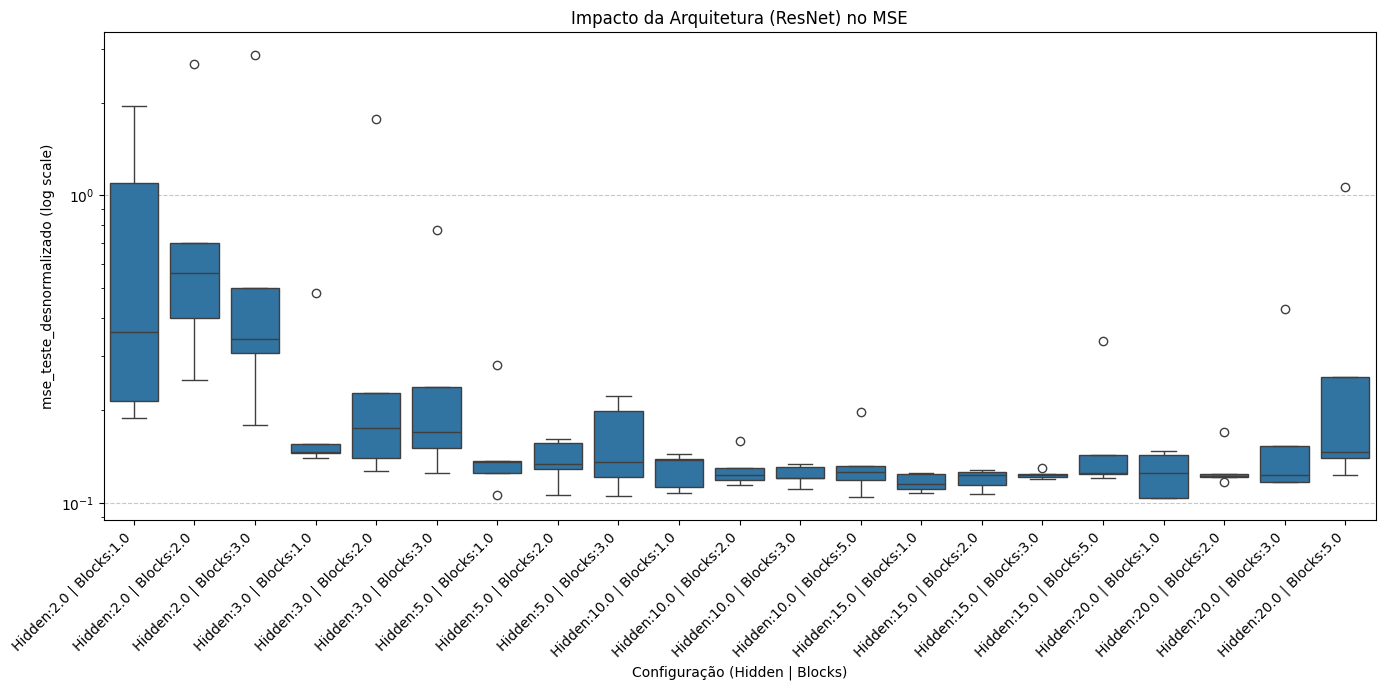

Gerando plot de histórico de loss dos melhores modelos...


NameError: name 'load_loss_history' is not defined

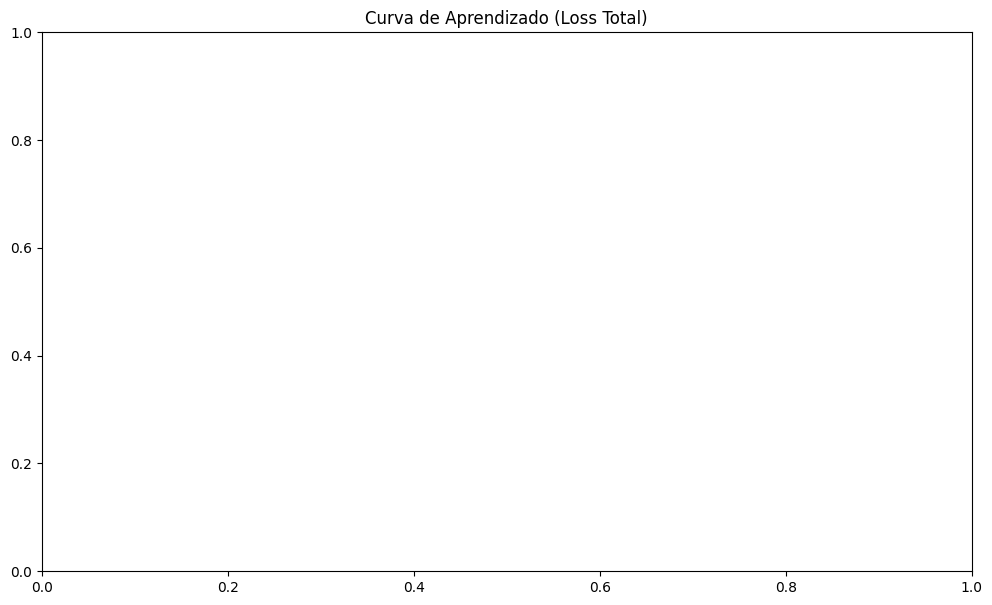

In [ ]:
# =============================================================================
# 2. PLOTS ESTATÍSTICOS (Análise Comparativa)
# =============================================================================
print("Gerando plots estatísticos...")

# --- Plot 2.1: Desempenho (MSE) por Tipo de Modelo ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='model_type', y=MSE_COLUMN)
plt.title('Desempenho (MSE Teste) por Tipo de Modelo')
plt.ylabel(f'{MSE_COLUMN} (log scale)')
plt.xlabel('Tipo de Modelo')
plt.yscale('log')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Plot 2.1: Desempenho (MSE) por Tipo de Modelo ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='model_type', y=LOSS_COLUMN)
plt.title('Desempenho LOSS por Tipo de Modelo')
plt.ylabel(f'{LOSS_COLUMN} (log scale)')
plt.xlabel('Tipo de Modelo')
plt.yscale('log')
plt.axhline(y=1/140**2, color='red', linestyle='--', linewidth=1.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Plot 2.2: Desempenho (MSE) vs. Complexidade (Parâmetros) ---
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_all, x='num_params', y=MSE_COLUMN, hue='model_type', s=100, alpha=0.8)
plt.title('Desempenho vs. Complexidade do Modelo')
plt.ylabel(f'{MSE_COLUMN} (log scale)')
plt.xlabel('Número de Parâmetros (log scale)')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Tipo de Modelo')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.3: Desempenho (MSE) vs. Eficiência (Tempo) ---
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_all, x='training_time_sec', y=MSE_COLUMN, hue='model_type', s=100, alpha=0.8)
plt.title('Desempenho vs. Eficiência do Modelo')
plt.ylabel(f'{MSE_COLUMN} (log scale)')
plt.xlabel('Tempo de Treinamento (segundos)')
plt.yscale('log')
plt.legend(title='Tipo de Modelo')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.4: Loss de Treino vs. MSE de Teste ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_all, x=LOSS_COLUMN, y=MSE_COLUMN, hue='model_type')
plt.title(f'Loss de Treino ({LOSS_COLUMN}) vs. MSE de Teste')
plt.xlabel(f'Loss de Treino (log scale)')
plt.ylabel(f'MSE de Teste (log scale)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.5: Loss de Treino vs. Número de Parâmetros ---
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_all, x='num_params', y=LOSS_COLUMN, hue='model_type', s=100, alpha=0.8)
plt.title(f'Loss Final de Treino vs. Complexidade do Modelo')
plt.ylabel(f'{LOSS_COLUMN} (log scale)')
plt.xlabel('Número de Parâmetros (log scale)')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Tipo de Modelo')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.6: Análise de Impacto da Arquitetura por Modelo ---
print("Gerando plots de impacto da arquitetura...")

# Mapeia os parâmetros de arquitetura para cada tipo de modelo
arch_params_map = {
    'MLP':    {'params': ['hidden', 'blocks'], 'labels': ['Hidden', 'Blocks']},
    'ResNet': {'params': ['hidden', 'blocks'], 'labels': ['Hidden', 'Blocks']},
    'QPINN':  {'params': ['n_qubits', 'n_layers'], 'labels': ['Qubits', 'Layers']}
}

for model_type, arch_info in arch_params_map.items():
    df_subset = df_all[df_all['model_type'] == model_type].copy()
    
    # Pula se não houver dados para este tipo de modelo
    if df_subset.empty:
        continue
        
    p1, p2 = arch_info['params']
    l1, l2 = arch_info['labels']
    
    # Pula se as colunas de arquitetura não estiverem no dataframe
    if p1 not in df_subset.columns or p2 not in df_subset.columns:
        print(f"AVISO: Pulando plot de arquitetura para '{model_type}' pois faltam as colunas '{p1}' ou '{p2}'.")
        continue

    # Cria uma coluna de "configuração" para o eixo X
    df_subset['config'] = f'{l1}:' + df_subset[p1].astype(str) + f' | {l2}:' + df_subset[p2].astype(str)
    
    # Ordena para o gráfico ficar bonito
    df_subset = df_subset.sort_values(by=[p1, p2])
    
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_subset, x='config', y=MSE_COLUMN)
    plt.title(f'Impacto da Arquitetura ({model_type}) no MSE')
    plt.ylabel(f'{MSE_COLUMN} (log scale)')
    plt.xlabel(f'Configuração ({l1} | {l2})')
    plt.yscale('log')
    plt.xticks(rotation=45, ha="right") # Rotaciona e alinha os labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Ajusta o layout para evitar sobreposição de labels
    plt.show()


# =============================================================================
# 3. PLOTS DE HISTÓRICO DE LOSS
# =============================================================================

# --- Plot 3.1: Curvas de Aprendizado (Melhores Modelos) ---
print("Gerando plot de histórico de loss dos melhores modelos...")
plt.figure(figsize=(12, 7))
plt.title('Curva de Aprendizado (Loss Total)')

# Encontra o melhor de cada tipo
model_types = df_all['model_type'].unique()
for m_type in model_types:
    df_subset = df_all[df_all['model_type'] == m_type]
    if df_subset.empty:
        continue
    
    best_run = df_subset.loc[df_subset[MSE_COLUMN].idxmin()]
    history = load_loss_history(best_run['loss_history_path'])
    
    if history and 'Total' in history:
        loss_total = history['Total']
        plt.plot(loss_total, label=f"Melhor {m_type} (Run: {best_run['run_id']})", alpha=0.8)

plt.xlabel('Época')
plt.ylabel('Loss Total (log scale)')
plt.yscale('log')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()

"""
# --- Plot 3.2: Curva de Aprendizado Média com Incerteza (por Seed) ---
print("Gerando plot de loss média com incerteza (por seed)...")
plt.figure(figsize=(14, 8))
plt.title('Loss Média com Incerteza (Agrupado por Configuração)')

config_cols_map = {
    'MLP': ['model_type', 'lr', 'epochs', 'activation', 'hidden', 'blocks'],
    'ResNet': ['model_type', 'lr', 'epochs', 'activation', 'hidden', 'blocks'],
    'QPINN': ['model_type', 'lr', 'epochs', 'n_qubits', 'n_layers']
}

# Itera sobre cada tipo de modelo presente no dataframe
for model_type, config_cols in config_cols_map.items():
    df_subset = df_all[df_all['model_type'] == model_type].copy()
    if df_subset.empty:
        continue

    # Verifica se todas as colunas de config existem para este subset
    if not all(col in df_subset.columns for col in config_cols):
        print(f"AVISO: Pulando análise de incerteza para '{model_type}' pois faltam colunas de configuração.")
        continue
    
    # Agrupa por configurações idênticas (ignorando a seed)
    grouped = df_subset.groupby(config_cols)
    
    for name, group in grouped:
        # Apenas plota se houver mais de uma seed para estatística
        if len(group) > 1:
            all_losses = []
            for idx, row in group.iterrows():
                history = load_loss_history(row['loss_history_path'])
                if history and 'Total' in history:
                    all_losses.append(history['Total'])
            
            if len(all_losses) < 2:
                continue
                
            # Garante que todos os históricos tenham o mesmo tamanho (trunca pelo menor)
            min_len = min(len(h) for h in all_losses)
            loss_array = np.array([h[:min_len] for h in all_losses])
            
            # Calcula a média e os percentis 25 e 75 ao longo das seeds (axis=0)
            mean_loss = np.mean(loss_array, axis=0)
            p25_loss = np.percentile(loss_array, 25, axis=0)
            p75_loss = np.percentile(loss_array, 75, axis=0)
            
            config_label = group.iloc[0]['run_id'].replace(f"_seed_{group.iloc[0]['seed']}", "")
            
            line, = plt.plot(mean_loss, label=f"{config_label} ({len(group)} seeds)")
            plt.fill_between(range(len(mean_loss)), p25_loss, p75_loss, color=line.get_color(), alpha=0.2)

plt.xlabel('Época')
plt.ylabel('Loss Total Média (log scale)')
plt.yscale('log')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()


# =============================================================================
# 4. PLOT DA SOLUÇÃO 3D (Melhor Modelo Geral)
# =============================================================================

print("Carregando o MELHOR modelo geral para plot 3D...")

# --- A. Encontrar o melhor modelo ---
best_run_config = df_all.loc[df_all[MSE_COLUMN].idxmin()]

print(f"\nMelhor Modelo Encontrado:")
print(f"  Run ID: {best_run_config['run_id']}")
print(f"  Tipo:   {best_run_config['model_type']}")
print(f"  MSE:    {best_run_config[MSE_COLUMN]:.6f}")
print(f"  Path:   {best_run_config['model_path']}")

# --- B. Recriar a arquitetura do modelo ---
model_type = best_run_config['model_type']
model = None

try:
    activation_str = best_run_config.get('activation', 'Tanh()')
    activation = activation_map[activation_str]

    if model_type == "MLP":
        model = MLP(hidden=int(best_run_config['hidden']), blocks=int(best_run_config['blocks']), 
                    activation=activation)
    
    elif model_type == "ResNet":
        model = ResNet(hidden=int(best_run_config['hidden']), blocks=int(best_run_config['blocks']), 
                       activation=activation)
    
    elif model_type == "QPINN":
        qnn = QuantumNeuralNetwork(n_qubits=int(best_run_config['n_qubits']), 
                                   n_layers=int(best_run_config['n_layers']))
        model = HybridCQN(classical_pre=None, qnn_block=qnn, classical_post=None)
    
    if model is None:
        raise ValueError(f"Tipo de modelo '{model_type}' não tratado no script de plot.")

    # --- C. Carregar os pesos salvos ---
    model.load_state_dict(tc.load(best_run_config['model_path']))
    model.eval() 
    print("Arquitetura recriada e pesos carregados com sucesso.")

except Exception as e:
    print(f"ERRO AO CARREGAR O MODELO: {e}")
    print("Pulando plot 3D. Verifique se as classes do modelo estão importadas.")
    exit()


# --- D. Gerar dados de teste (com a mesma seed do treino) ---
bse = BlackScholes(eps=1e-10)
data_teste = bse.generate_data(seed=42)

S_test, t_test, V_true = data_teste['domain']
S_test_flat, t_test_flat, V_true_flat = S_test.ravel(), t_test.ravel(), V_true.ravel()

# --- E. Fazer a predição com o modelo carregado ---
_S_test_norm = tc.tensor(S_test / S_max).float()
_t_test_norm = tc.tensor(t_test / T).float()

with tc.no_grad():
    V_pred_norm = model(tc.cat([_S_test_norm, _t_test_norm], dim=1))

V_pred = V_pred_norm.numpy() * V_max
V_pred_flat = V_pred.ravel()

# --- F. Plotar os gráficos 3D ---
print("Gerando plots 3D da solução (Verdadeiro vs. Predito)...")

fig = plt.figure(figsize=(24, 8))
fig.suptitle(f"Comparação da Solução - Melhor Modelo ({best_run_config['run_id']})", fontsize=16)

# Plot 1: Solução Verdadeira
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.set_title('Solução Verdadeira (Black-Scholes)')
ax1.plot_trisurf(S_test_flat, t_test_flat, V_true_flat, cmap='viridis', edgecolor='none', alpha=0.9)
ax1.set_xlabel('Preço do Ativo (S)')
ax1.set_ylabel('Tempo (t)')
ax1.set_zlabel('Preço da Opção (V)')
ax1.view_init(30, -120)

# Plot 2: Solução Predita (PINN)
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.set_title('Solução Predita (PINN)')
ax2.plot_trisurf(S_test_flat, t_test_flat, V_pred_flat, cmap='viridis', edgecolor='none', alpha=0.9)
ax2.set_xlabel('Preço do Ativo (S)')
ax2.set_ylabel('Tempo (t)')
ax2.set_zlabel('Preço da Opção (V)')
ax2.view_init(30, -120)

# Plot 3: Erro (Verdadeiro - Predito)
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
erro = V_true_flat - V_pred_flat
ax3.set_title('Erro Absoluto (Verdadeiro - Predito)')
sc = ax3.plot_trisurf(S_test_flat, t_test_flat, erro, cmap='coolwarm', edgecolor='none', alpha=0.9)
fig.colorbar(sc, ax=ax3, shrink=0.5)
ax3.set_xlabel('Preço do Ativo (S)')
ax3.set_ylabel('Tempo (t)')
ax3.set_zlabel('Erro')
ax3.view_init(30, -120)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nAnálise concluída.")
"""

Carregando sumários de resultados...
Carregado 61 runs de 'experimentos_pinn/sumario_quantico.csv'
Carregado 144 runs de 'experimentos_pinn/sumario_cquantico.csv'

--- Sumário dos Experimentos (Amostra) ---
  model_type run_id_prefix     lr  epochs  activation entangler  n_qubits  \
0        QNN     qnn_basic  0.002   15000         NaN     basic         2   
1        QNN     qnn_basic  0.002   15000         NaN     basic         2   
2        QNN     qnn_basic  0.002   15000         NaN     basic         2   
3        QNN     qnn_basic  0.002   15000         NaN     basic         2   
4        QNN     qnn_basic  0.002   15000         NaN     basic         2   

   n_layers  seed                                run_id  ...  \
0         1  1924  qnn_basic_n_qubits_2_n_l_1_seed_1924  ...   
1         1  1925  qnn_basic_n_qubits_2_n_l_1_seed_1925  ...   
2         1  1926  qnn_basic_n_qubits_2_n_l_1_seed_1926  ...   
3         2  1924  qnn_basic_n_qubits_2_n_l_2_seed_1924  ...   
4         

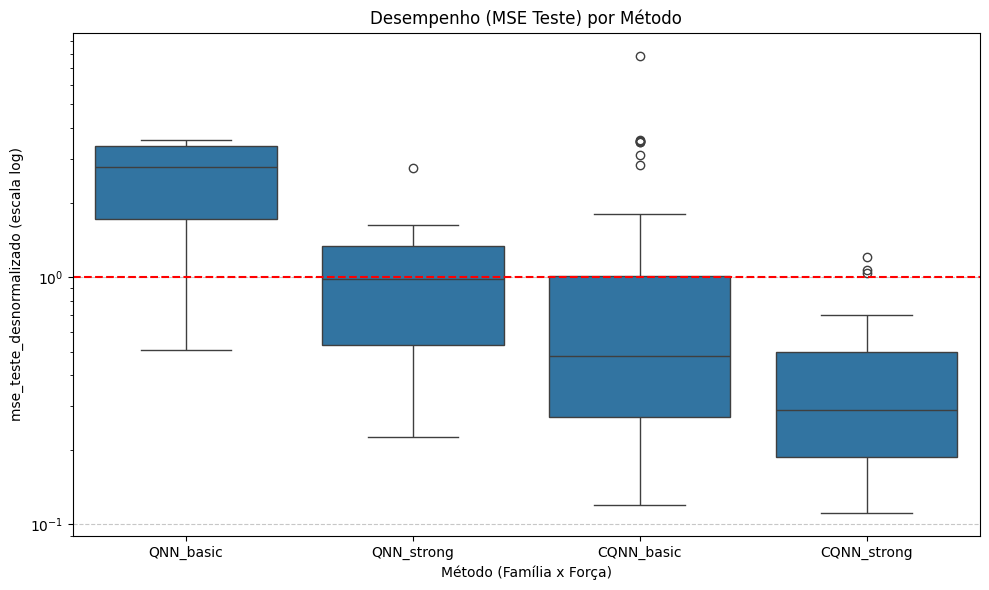

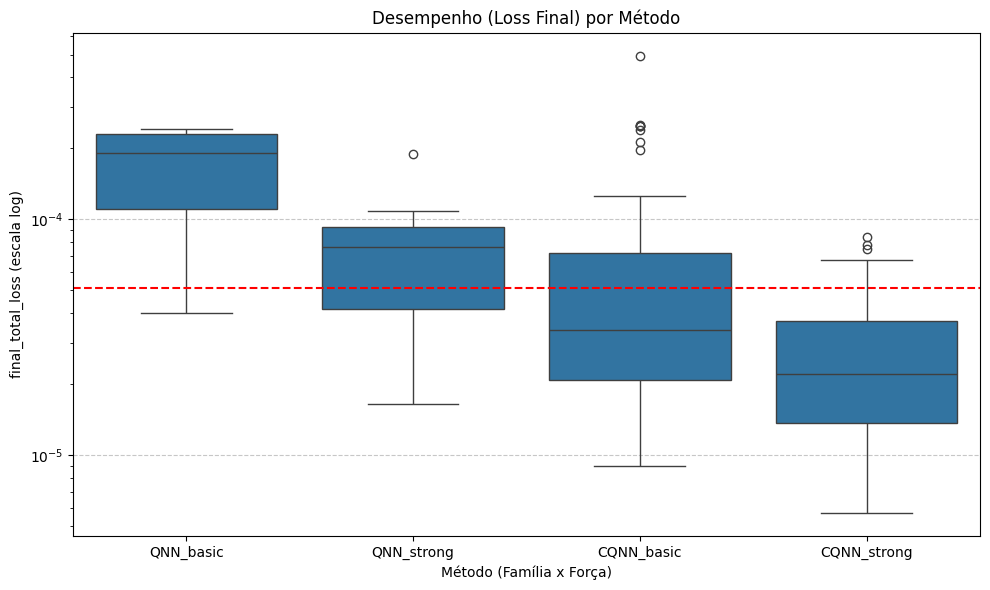

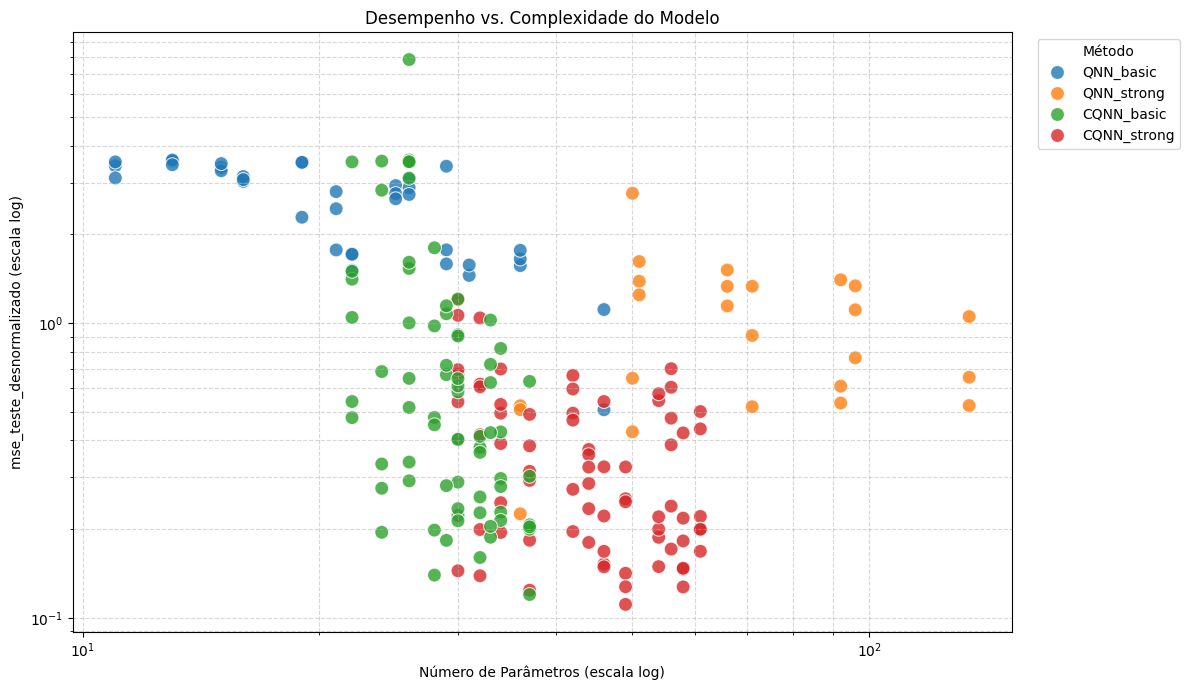

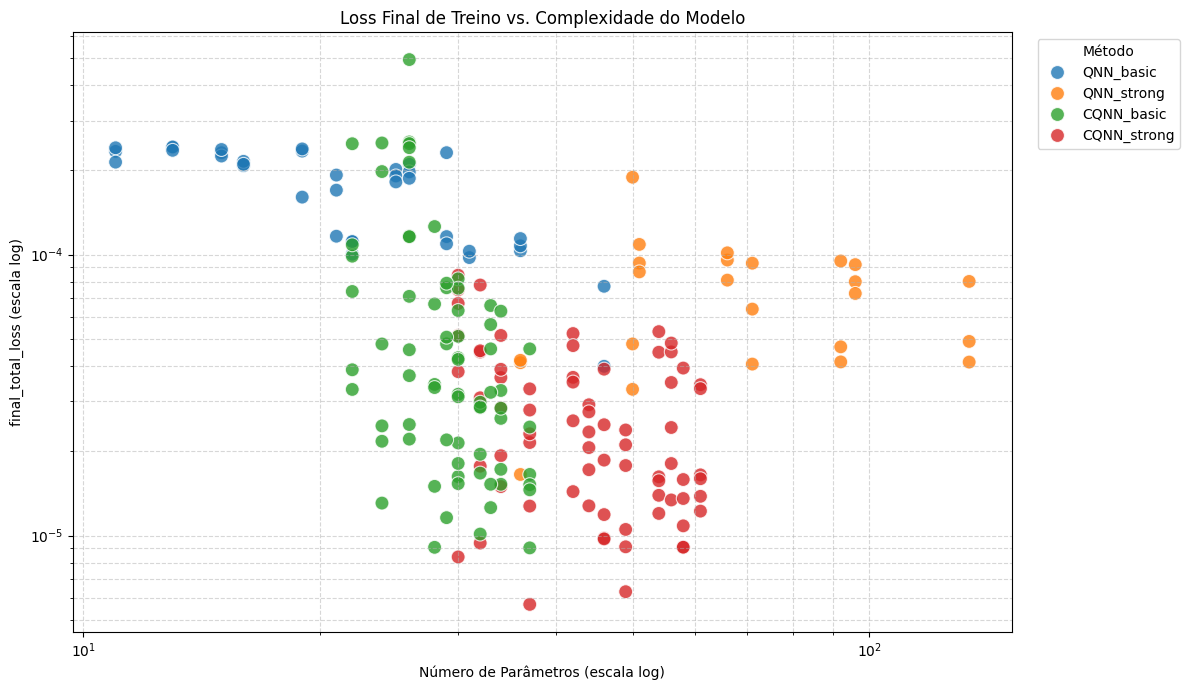

Gerando plots de impacto da arquitetura...


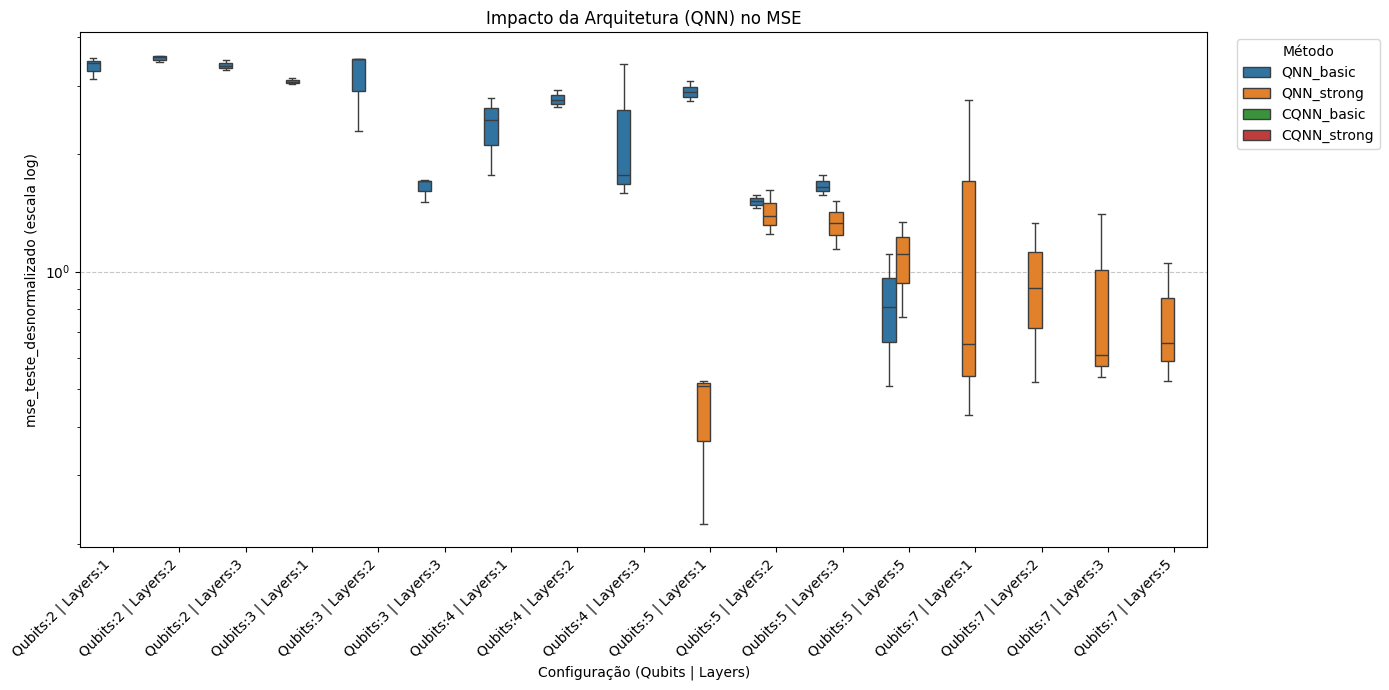

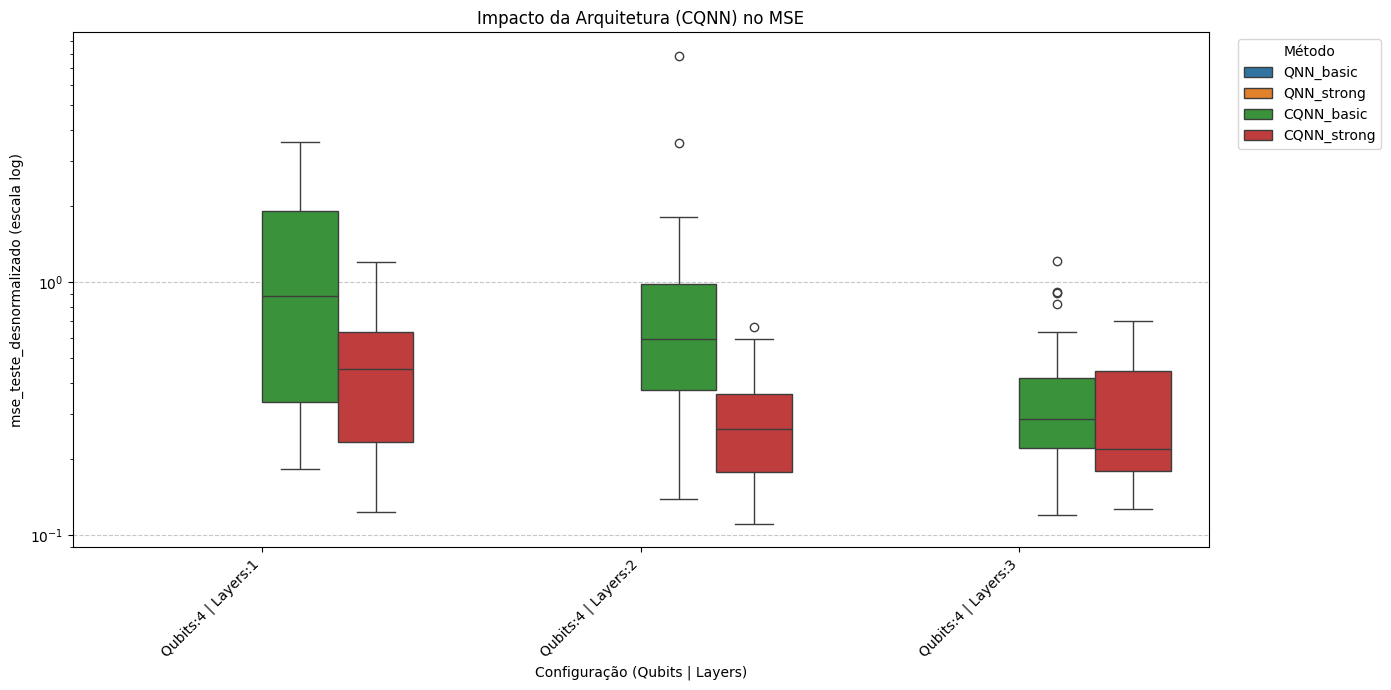

Gerando plot de histórico de loss dos melhores modelos...


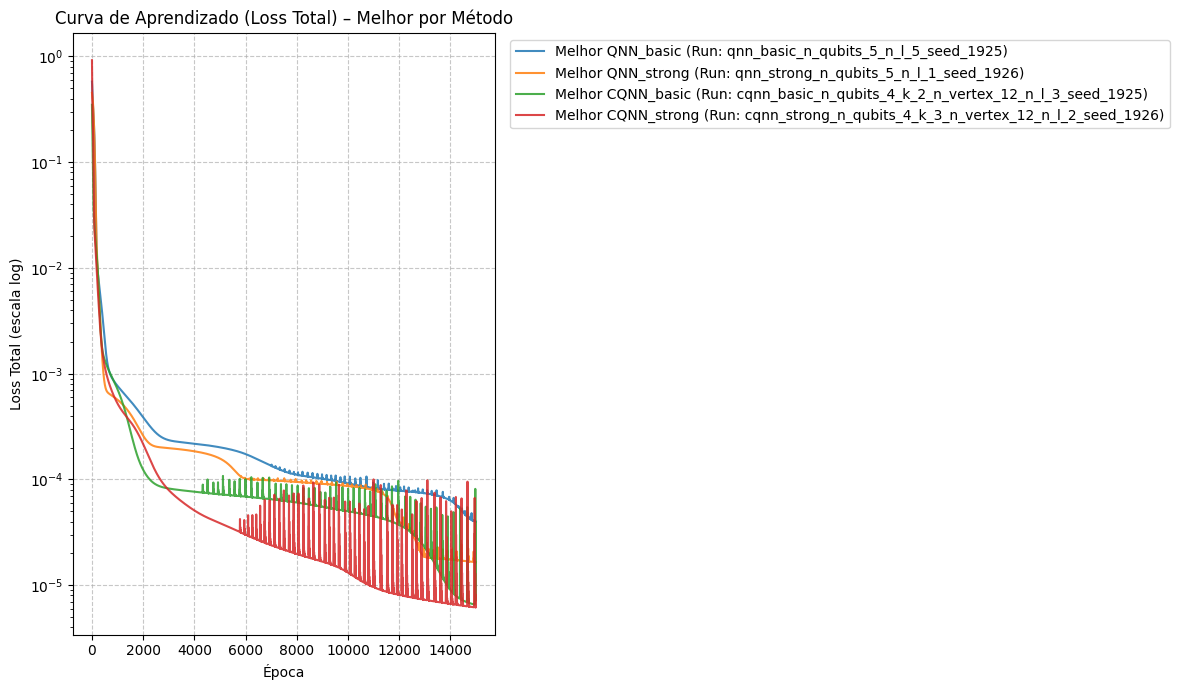

In [ ]:
# Diretório onde os resultados foram salvos
RESULTS_DIR = "experimentos_pinn"

SUMMARY_QUANTUM_PATH = os.path.join(RESULTS_DIR, "sumario_quantico.csv")
SUMMARY_CQUANTUM_PATH = os.path.join(RESULTS_DIR, "sumario_cquantico.csv")

# Métrica principal para avaliar os modelos (use a desnormalizada)
MSE_COLUMN = 'mse_teste_desnormalizado'
LOSS_COLUMN = 'final_total_loss'  # ou 'mean_last_100_loss'

# Mapeamento de string de ativação para objeto (necessário para recarregar)
activation_map = {
    "Tanh()": nn.Tanh(),
    "ReLU()": nn.ReLU(),
    # Adicione outras ativações se você as usou
}

# Constantes de normalização (as mesmas usadas no treino)
S_max = 160.0
T = 1.0
V_max = 140.0




# =============================================================================
# 0.1 HELPERS PARA NORMALIZAR TIPO E FORÇA (basic/strong) -> CRIAR 'method'
# =============================================================================
def normalize_family(x: str) -> str:
    """Normaliza o nome do tipo de modelo para 'QNN' ou 'CQNN'."""
    if not isinstance(x, str):
        return "QNN"
    x_low = x.lower()
    # variações comuns
    if "cquant" in x_low or "c-qnn" in x_low or "cqnn" in x_low:
        return "CQNN"
    if "qnn" in x_low:
        return "QNN"
    # fallback
    return x.upper()


def infer_strength(row) -> str:
    """
    Tenta inferir 'basic' ou 'strong' a partir de colunas como 'entangler' e 'run_id_prefix'.
    """
    # prioridade 1: entangler
    ent = row.get('entangler', None)
    if isinstance(ent, str):
        el = ent.lower()
        if 'strong' in el:
            return 'strong'
        if 'basic' in el:
            return 'basic'
    # prioridade 2: run_id_prefix
    rip = row.get('run_id_prefix', None)
    if isinstance(rip, str):
        rl = rip.lower()
        if 'strong' in rl:
            return 'strong'
        if 'basic' in rl:
            return 'basic'
    # prioridade 3: run_id
    rid = row.get('run_id', None)
    if isinstance(rid, str):
        rl = rid.lower()
        if 'strong' in rl:
            return 'strong'
        if 'basic' in rl:
            return 'basic'
    # fallback
    return 'basic'


def build_method_col(df: pd.DataFrame) -> pd.DataFrame:
    """Cria coluna 'method' = '{FAMILY}_{STRENGTH}' (e.g., 'QNN_basic', 'CQNN_strong')."""
    df = df.copy()
    # normaliza família
    df['model_family'] = df['model_type'].apply(normalize_family) if 'model_type' in df.columns \
                         else 'QNN'
    # força (basic/strong)
    df['strength'] = df.apply(infer_strength, axis=1)
    # compõe método
    df['method'] = df['model_family'].astype(str) + "_" + df['strength'].astype(str)
    # ordenação preferida
    method_order = ['QNN_basic', 'QNN_strong', 'CQNN_basic', 'CQNN_strong']
    df['method'] = pd.Categorical(df['method'], categories=method_order, ordered=True)
    return df


# =============================================================================
# 1. CARREGAR OS DADOS DO SUMÁRIO
# =============================================================================
print("Carregando sumários de resultados...")
all_dfs = []

try:
    df_q = pd.read_csv(SUMMARY_QUANTUM_PATH)
    all_dfs.append(df_q)
    print(f"Carregado {len(df_q)} runs de '{SUMMARY_QUANTUM_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_QUANTUM_PATH}' não encontrado. Pulando.")

try:
    df_cq = pd.read_csv(SUMMARY_CQUANTUM_PATH)
    all_dfs.append(df_cq)
    print(f"Carregado {len(df_cq)} runs de '{SUMMARY_CQUANTUM_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CQUANTUM_PATH}' não encontrado. Pulando.")

if not all_dfs:
    print("ERRO: Nenhum arquivo de sumário encontrado. Rode 'run_experiments.py' primeiro.")
    raise SystemExit(1)

# Concatena todos os dataframes para análise comparativa
df_all = pd.concat(all_dfs, ignore_index=True)

# Garantir tipos numéricos
for col in [MSE_COLUMN, LOSS_COLUMN, 'num_params', 'training_time_sec']:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# Construir a coluna 'method'
df_all = build_method_col(df_all)

print("\n--- Sumário dos Experimentos (Amostra) ---")
print(df_all.head())
print("\n")


# =============================================================================
# 2. PLOTS ESTATÍSTICOS (Análise Comparativa)
# =============================================================================
print("Gerando plots estatísticos...")

# --- Plot 2.1: Desempenho (MSE) por Método ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='method', y=MSE_COLUMN)
plt.title('Desempenho (MSE Teste) por Método')
plt.ylabel(f'{MSE_COLUMN} (escala log)')
plt.xlabel('Método (Família x Força)')
plt.yscale('log')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 2.2: LOSS por Método ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='method', y=LOSS_COLUMN)
plt.title('Desempenho (Loss Final) por Método')
plt.ylabel(f'{LOSS_COLUMN} (escala log)')
plt.xlabel('Método (Família x Força)')
plt.yscale('log')
# guia opcional (ex.: 1/140**2)
try:
    plt.axhline(y=1/(V_max**2), color='red', linestyle='--', linewidth=1.5)
except Exception:
    pass
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 2.3: Desempenho (MSE) vs. Complexidade (Parâmetros) ---
if {'num_params', MSE_COLUMN}.issubset(df_all.columns):
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df_all, x='num_params', y=MSE_COLUMN, hue='method', s=100, alpha=0.8)
    plt.title('Desempenho vs. Complexidade do Modelo')
    plt.ylabel(f'{MSE_COLUMN} (escala log)')
    plt.xlabel('Número de Parâmetros (escala log)')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(title='Método', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- Plot 2.5: Loss de Treino vs. Número de Parâmetros ---
if {'num_params', LOSS_COLUMN}.issubset(df_all.columns):
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df_all, x='num_params', y=LOSS_COLUMN, hue='method', s=100, alpha=0.8)
    plt.title('Loss Final de Treino vs. Complexidade do Modelo')
    plt.ylabel(f'{LOSS_COLUMN} (escala log)')
    plt.xlabel('Número de Parâmetros (escala log)')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(title='Método', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# --- Plot 2.6: Análise de Impacto da Arquitetura por Família (QNN / CQNN) ---
print("Gerando plots de impacto da arquitetura...")

# Tentamos duas famílias; se só houver QNN, apenas QNN será plotado.
for family in ['QNN', 'CQNN']:
    df_subset = df_all[df_all['model_family'] == family].copy()
    if df_subset.empty:
        continue

    # Detecta automaticamente colunas de arquitetura plausíveis
    # (ajuste se você quiser algo fixo)
    candidate_pairs = [
        ('n_qubits', 'n_layers'),
        ('hidden', 'blocks'),
        ('classical_hidden', 'classical_blocks')
    ]
    pair_found = None
    for p1, p2 in candidate_pairs:
        if p1 in df_subset.columns and p2 in df_subset.columns:
            pair_found = (p1, p2)
            break

    if pair_found is None:
        print(f"AVISO: Pulando plot de arquitetura para '{family}' (não encontrei pares de colunas de arquitetura).")
        continue

    p1, p2 = pair_found
    # rótulos bonitos
    label_map = {
        'n_qubits': 'Qubits',
        'n_layers': 'Layers',
        'hidden': 'Hidden',
        'blocks': 'Blocks',
        'classical_hidden': 'Classical Hidden',
        'classical_blocks': 'Classical Blocks'
    }
    l1, l2 = label_map.get(p1, p1), label_map.get(p2, p2)

    # Cria config textual
    df_subset['config'] = f'{l1}:' + df_subset[p1].astype(str) + f' | {l2}:' + df_subset[p2].astype(str)
    df_subset = df_subset.sort_values(by=[p1, p2])

    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_subset, x='config', y=MSE_COLUMN, hue='method')
    plt.title(f'Impacto da Arquitetura ({family}) no MSE')
    plt.ylabel(f'{MSE_COLUMN} (escala log)')
    plt.xlabel(f'Configuração ({l1} | {l2})')
    plt.yscale('log')
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Método', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# =============================================================================
# 3. PLOTS DE HISTÓRICO DE LOSS
# =============================================================================
print("Gerando plot de histórico de loss dos melhores modelos...")
plt.figure(figsize=(12, 7))
plt.title('Curva de Aprendizado (Loss Total) – Melhor por Método')

# Encontra o melhor de cada método
if 'method' in df_all.columns and LOSS_COLUMN in df_all.columns and MSE_COLUMN in df_all.columns:
    methods = [m for m in df_all['method'].cat.categories if m in df_all['method'].unique().tolist()] \
              if hasattr(df_all['method'], 'cat') else df_all['method'].unique()
    for meth in methods:
        df_subset = df_all[df_all['method'] == meth]
        if df_subset.empty:
            continue

        # melhor run por MSE
        try:
            idx_best = df_subset[MSE_COLUMN].idxmin()
        except ValueError:
            continue

        best_run = df_all.loc[idx_best]
        history_path = best_run.get('loss_history_path', None)
        if not isinstance(history_path, str):
            print(f"AVISO: {meth} sem 'loss_history_path'.")
            continue

        history = load_loss_history(history_path)
        if history and 'Total' in history:
            loss_total = history['Total']
            plt.plot(loss_total, label=f"Melhor {meth} (Run: {best_run.get('run_id', 'N/A')})", alpha=0.85)

plt.xlabel('Época')
plt.ylabel('Loss Total (escala log)')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


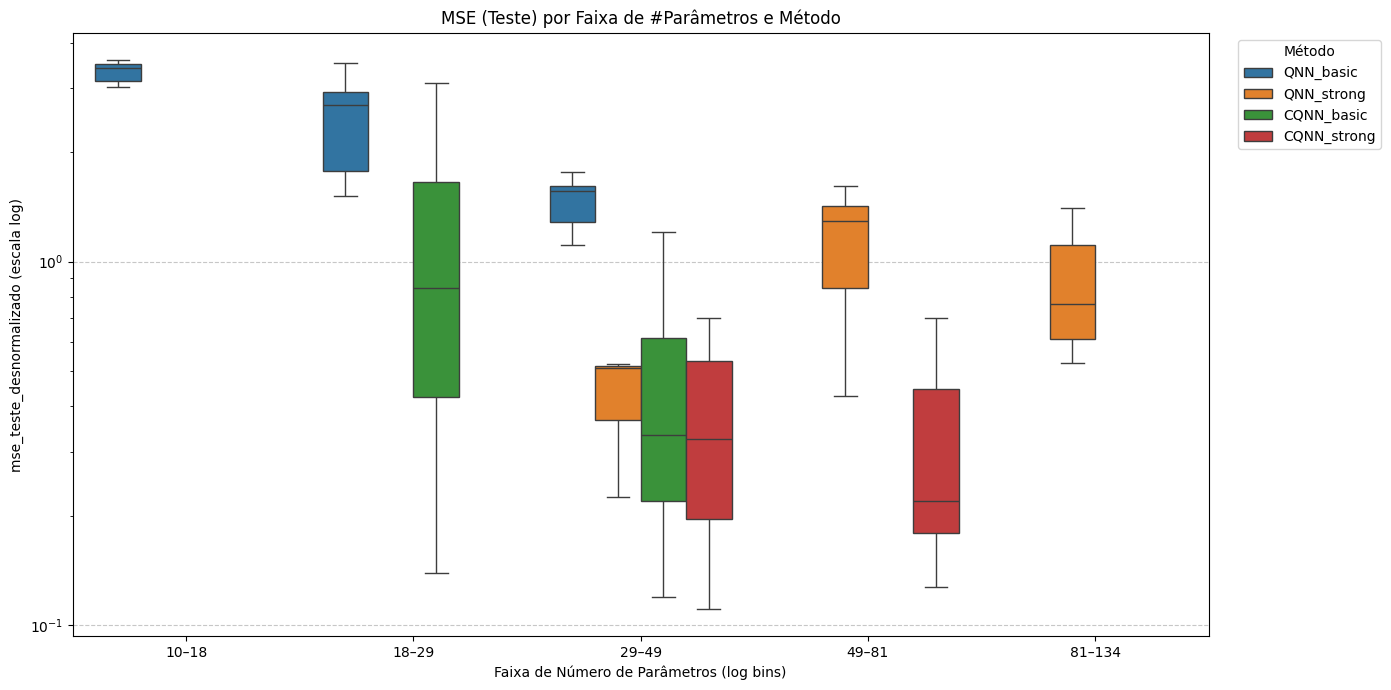

In [ ]:
# Cria bins em escala log (ajuste qtd conforme desejar)
bins = np.logspace(np.log10(df_all['num_params'].min()),
                   np.log10(df_all['num_params'].max()),
                   num=6)  # 5 faixas
labels = [f'{int(bins[i])}–{int(bins[i+1])}' for i in range(len(bins)-1)]

df_binned = df_all.copy()
df_binned['params_bin'] = pd.cut(df_binned['num_params'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_binned, x='params_bin', y=MSE_COLUMN, hue='method', showfliers=False)
plt.title('MSE (Teste) por Faixa de #Parâmetros e Método')
plt.ylabel(f'{MSE_COLUMN} (escala log)')
plt.xlabel('Faixa de Número de Parâmetros (log bins)')
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Método', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# =============================================================================
# 4. THRESHOLD de convergência
# =============================================================================
# Defina o limiar de loss que caracteriza "convergiu"
THRESH_LOSS = 1/ (V_max**2)   # ex.: mesmo que você já usa nos plots (~1/140^2)
# THRESH_LOSS = 1e-3            # (opção manual)
print("Threshold de loss:", THRESH_LOSS)


Threshold de loss: 5.102040816326531e-05


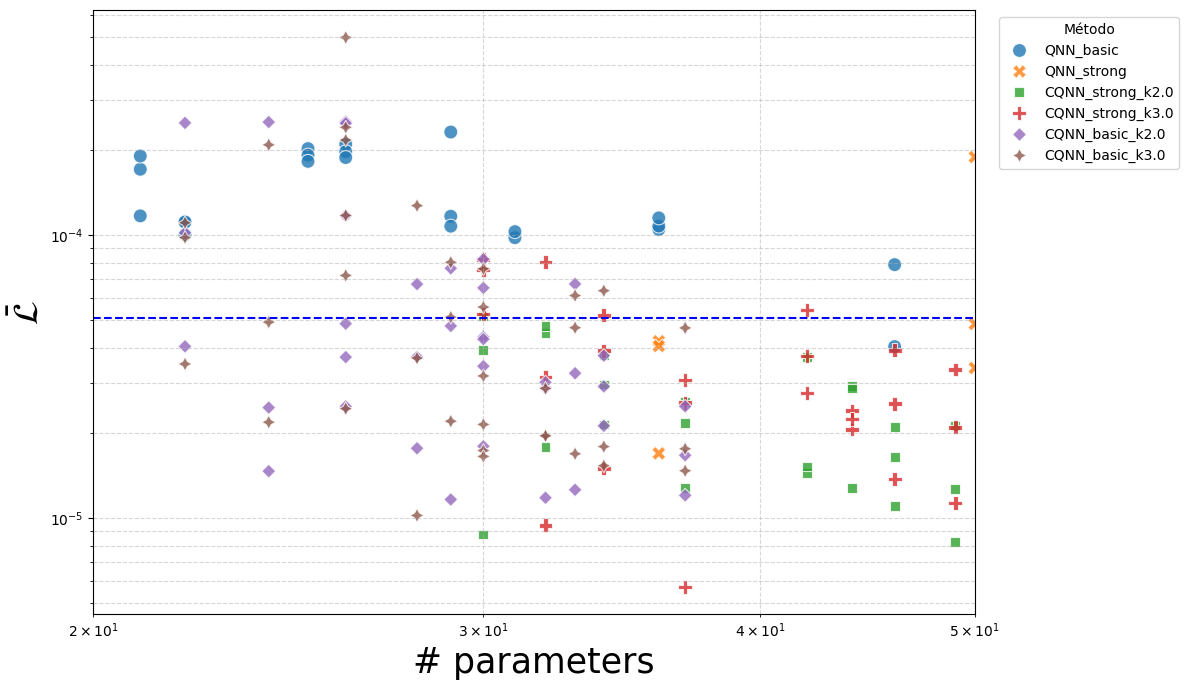

In [ ]:
df_plot = df_all.copy()

# Cria uma nova coluna diferenciando CQNN pelo valor de k
df_plot['method_k'] = df_plot.apply(
    lambda r: f"{r['method']}_k{r['k']}" if r['model_family']=='CQNN' else r['method'],
    axis=1
)

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_plot, x='num_params', y='mean_last_100_loss',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlim(20, 50)
plt.tight_layout()
plt.show()


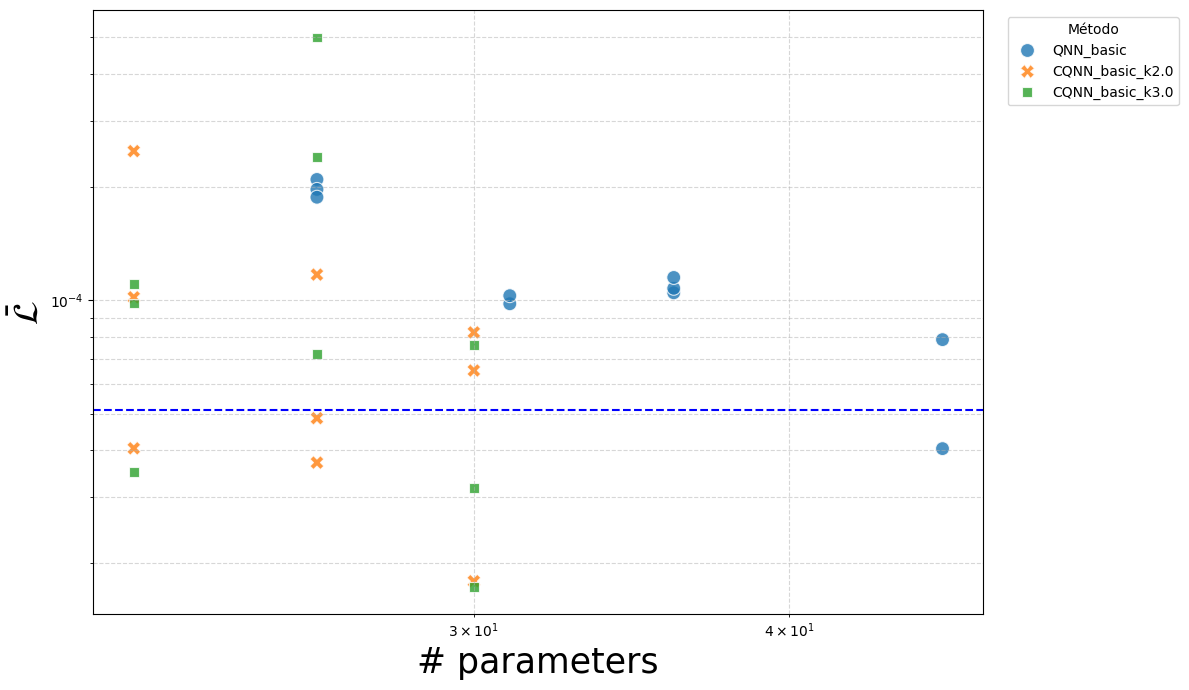

In [ ]:
# lista dos métodos que você quer incluir no gráfico
selecionados = [
    'QNN_basic',
    #'QNN_strong',
    'CQNN_basic_k2.0',
    'CQNN_basic_k3.0'
    #'CQNN_strong_k2.0'
]

# mantém apenas os métodos escolhidos e com n_qubits = 3
# define o filtro separadamente
filtro_qnn  = (df_plot['model_family'] == 'QNN')  & (df_plot['n_qubits']  == 5)
filtro_cqnn = (df_plot['model_family'] == 'CQNN') & (df_plot['n_vertex'] == 5)

# combina
df_sel = df_plot[(filtro_qnn | filtro_cqnn) & df_plot['method_k'].isin(selecionados)]

# plota
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_sel, x='num_params', y='mean_last_100_loss',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()



Melhores por método (ordenado):
- CQNN_basic_k2.0: run_id=cqnn_basic_n_qubits_4_k_2_n_vertex_5_n_l_3_seed_1926  mean_last_100_loss=1.79434e-05
- CQNN_basic_k3.0: run_id=cqnn_basic_n_qubits_4_k_3_n_vertex_5_n_l_3_seed_1926  mean_last_100_loss=1.73319e-05
- QNN_basic: run_id=qnn_basic_n_qubits_5_n_l_5_seed_1925  mean_last_100_loss=4.03721e-05


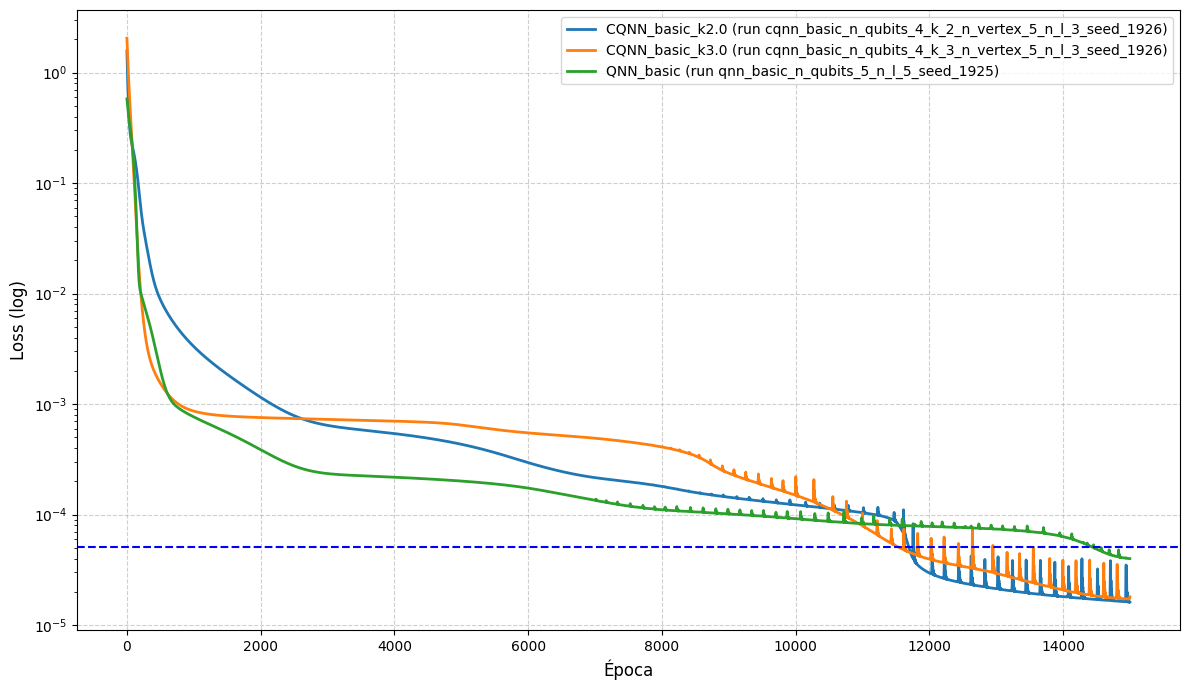

In [ ]:
# =========================
# Melhor run por método + plot do histórico
# =========================

METRIC = 'mean_last_100_loss'   # troque para 'mean_last_100_loss' se preferir
HISTORY_KEY = 'Total'                 # ajuste se seu JSON usar outra chave

melhores = []

for metodo in sorted(df_sel['method_k'].unique()):
    df_m = df_sel[df_sel['method_k'] == metodo]
    if df_m.empty or METRIC not in df_m.columns:
        continue
    # escolhe índice do melhor (menor métrica)
    idx_best = df_m[METRIC].idxmin()
    best_row = df_sel.loc[idx_best]
    melhores.append(best_row)

# imprime um resumo rápido
print("Melhores por método (ordenado):")
for r in melhores:
    print(f"- {r['method_k']}: run_id={r['run_id']}  {METRIC}={r[METRIC]:.6g}")

# plota histórico de cada melhor método
plt.figure(figsize=(12, 7))
for r in melhores:
    hist = load_loss_history(r['loss_history_path'])
    if not hist:
        print(f"AVISO: sem histórico para {r['method_k']} -> {r['loss_history_path']}")
        continue
    if HISTORY_KEY not in hist:
        # tenta chaves alternativas comuns
        key_alt = next((k for k in hist.keys() if k.lower() in ['total','loss','train','train_total']), None)
        if key_alt is None:
            print(f"AVISO: chave '{HISTORY_KEY}' não encontrada no histórico de {r['method_k']}.")
            continue
        serie = hist[key_alt]
    else:
        serie = hist[HISTORY_KEY]

    plt.plot(serie, label=f"{r['method_k']} (run {r['run_id']})", linewidth=2),


plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.yscale('log')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss (log)', fontsize=12)
plt.grid(True, ls='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


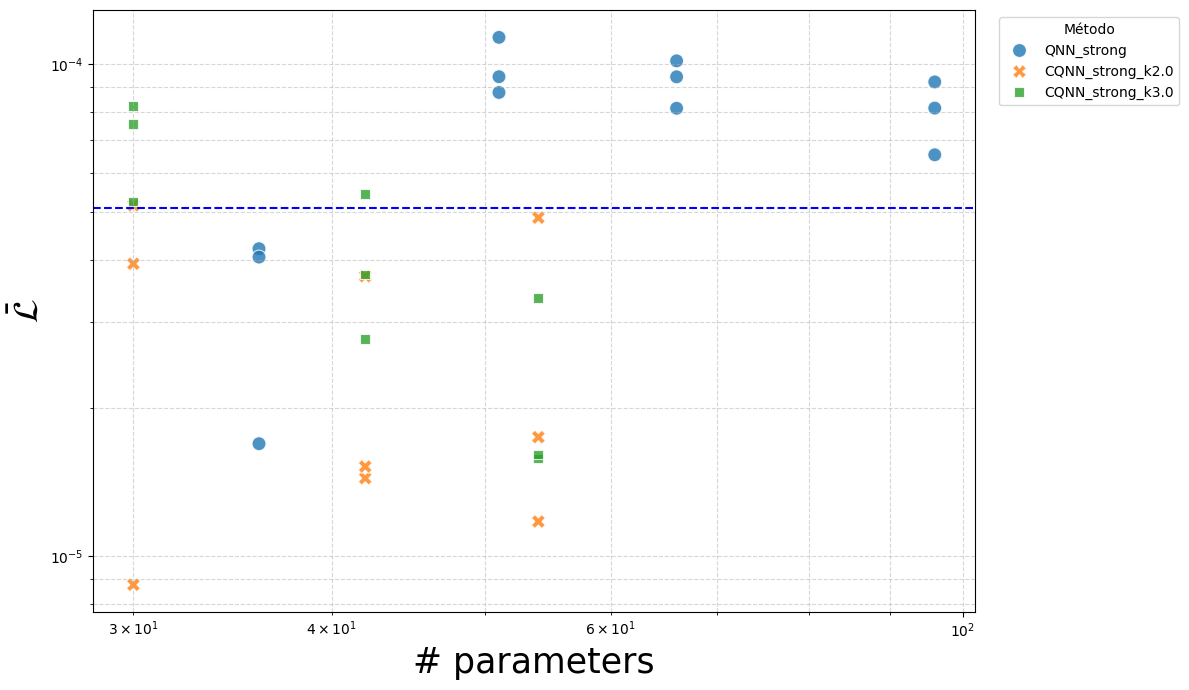

In [ ]:
# lista dos métodos que você quer incluir no gráfico
selecionados = [
    #'QNN_basic',
    'QNN_strong',
    #'CQNN_basic_k2.0',
    #'CQNN_basic_k3.0'
    'CQNN_strong_k2.0',
    'CQNN_strong_k3.0'
]

# mantém apenas os métodos escolhidos e com n_qubits = 3
# define o filtro separadamente
filtro_qnn  = (df_plot['model_family'] == 'QNN')  & (df_plot['n_qubits']  == 5)
filtro_cqnn = (df_plot['model_family'] == 'CQNN') & (df_plot['n_vertex'] == 5)

# combina
df_sel = df_plot[(filtro_qnn | filtro_cqnn) & df_plot['method_k'].isin(selecionados)]

# plota
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_sel, x='num_params', y='mean_last_100_loss',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# lista dos métodos que você quer incluir no gráfico
selecionados = [
    'QNN_basic',
    #'QNN_strong',
    'CQNN_basic_k2.0',
    'CQNN_basic_k3.0'
    #'CQNN_strong_k2.0',
    #'CQNN_strong_k3.0'
]

# mantém apenas os métodos escolhidos e com n_qubits = 3
# define o filtro separadamente
filtro_qnn  = (df_plot['model_family'] == 'QNN')  & (df_plot['n_qubits']  == 4)
filtro_cqnn = (df_plot['model_family'] == 'CQNN') & (df_plot['n_vertex'] == 12)

# combina
df_sel = df_plot[(filtro_qnn | filtro_cqnn) & df_plot['method_k'].isin(selecionados)]

# plota
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_sel, x='num_params', y='mse_teste_desnormalizado',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=1, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

Melhores por método (ordenado):
- CQNN_basic_k2.0: run_id=cqnn_basic_n_qubits_4_k_2_n_vertex_12_n_l_1_seed_1924  mean_last_100_loss=1.16366e-05
- CQNN_basic_k3.0: run_id=cqnn_basic_n_qubits_4_k_3_n_vertex_12_n_l_3_seed_1926  mean_last_100_loss=1.47042e-05
- QNN_basic: run_id=qnn_basic_n_qubits_4_n_l_3_seed_1926  mean_last_100_loss=0.000107546


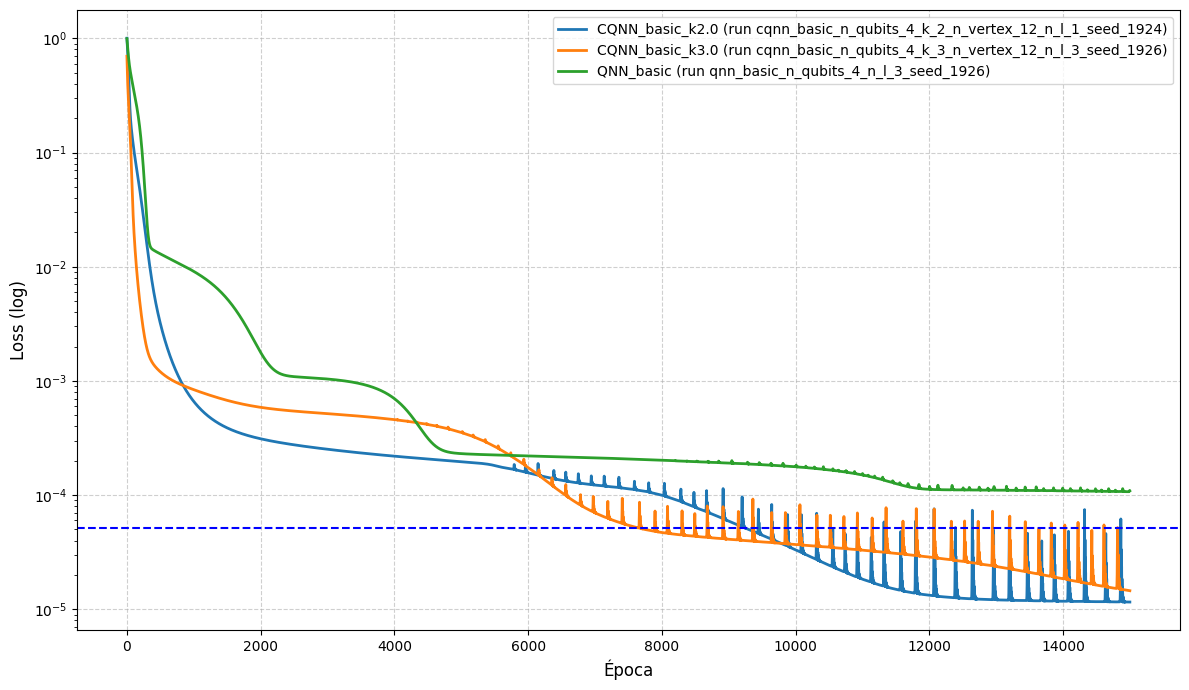

In [ ]:
# =========================
# Melhor run por método + plot do histórico
# =========================

METRIC = 'mean_last_100_loss'   # troque para 'mean_last_100_loss' se preferir
HISTORY_KEY = 'Total'                 # ajuste se seu JSON usar outra chave

melhores = []

for metodo in sorted(df_sel['method_k'].unique()):
    df_m = df_sel[df_sel['method_k'] == metodo]
    if df_m.empty or METRIC not in df_m.columns:
        continue
    # escolhe índice do melhor (menor métrica)
    idx_best = df_m[METRIC].idxmin()
    best_row = df_sel.loc[idx_best]
    melhores.append(best_row)

# imprime um resumo rápido
print("Melhores por método (ordenado):")
for r in melhores:
    print(f"- {r['method_k']}: run_id={r['run_id']}  {METRIC}={r[METRIC]:.6g}")

# plota histórico de cada melhor método
plt.figure(figsize=(12, 7))
for r in melhores:
    hist = load_loss_history(r['loss_history_path'])
    if not hist:
        print(f"AVISO: sem histórico para {r['method_k']} -> {r['loss_history_path']}")
        continue
    if HISTORY_KEY not in hist:
        # tenta chaves alternativas comuns
        key_alt = next((k for k in hist.keys() if k.lower() in ['total','loss','train','train_total']), None)
        if key_alt is None:
            print(f"AVISO: chave '{HISTORY_KEY}' não encontrada no histórico de {r['method_k']}.")
            continue
        serie = hist[key_alt]
    else:
        serie = hist[HISTORY_KEY]

    plt.plot(serie, label=f"{r['method_k']} (run {r['run_id']})", linewidth=2),


plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.yscale('log')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss (log)', fontsize=12)
plt.grid(True, ls='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


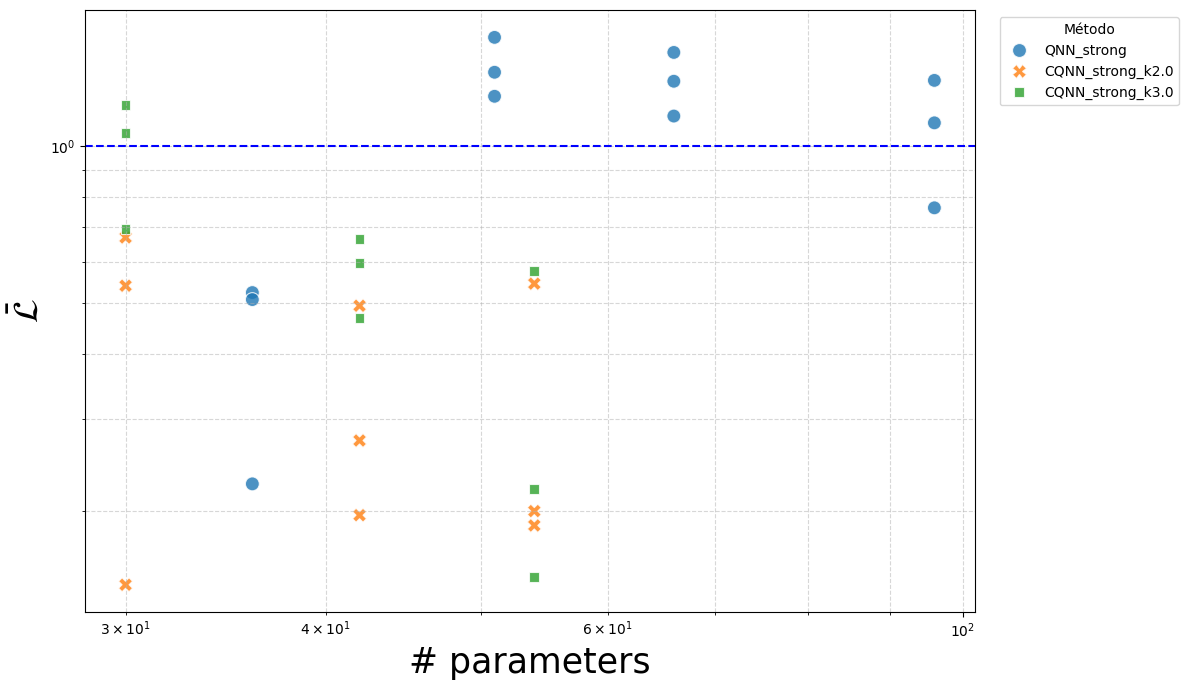

In [ ]:
# lista dos métodos que você quer incluir no gráfico
selecionados = [
    #'QNN_basic',
    'QNN_strong',
    #'CQNN_basic_k2.0',
    #'CQNN_basic_k3.0'
    'CQNN_strong_k2.0',
    'CQNN_strong_k3.0'
]

# mantém apenas os métodos escolhidos e com n_qubits = 3
# define o filtro separadamente
filtro_qnn  = (df_plot['model_family'] == 'QNN')  & (df_plot['n_qubits']  == 5)
filtro_cqnn = (df_plot['model_family'] == 'CQNN') & (df_plot['n_vertex'] == 5 )

# combina
df_sel = df_plot[(filtro_qnn | filtro_cqnn) & df_plot['method_k'].isin(selecionados)]

# plota
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_sel, x='num_params', y='mse_teste_desnormalizado',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=1, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

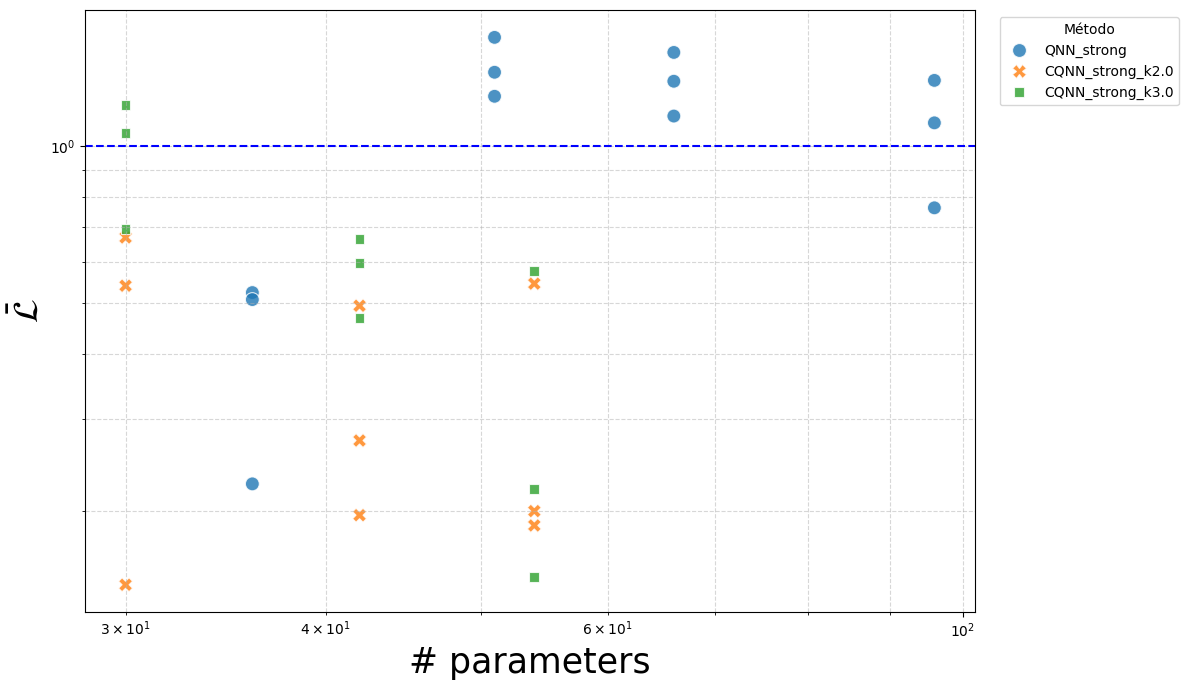

In [ ]:
# lista dos métodos que você quer incluir no gráfico
selecionados = [
    #'QNN_basic',
    'QNN_strong',
    #'CQNN_basic_k2.0',
    #'CQNN_basic_k3.0'
    'CQNN_strong_k2.0',
    'CQNN_strong_k3.0'
]

# mantém apenas os métodos escolhidos e com n_qubits = 3
# define o filtro separadamente
filtro_qnn  = (df_plot['model_family'] == 'QNN')  & (df_plot['n_qubits']  == 5)
filtro_cqnn = (df_plot['model_family'] == 'CQNN') & (df_plot['n_vertex'] == 5)

# combina
df_sel = df_plot[(filtro_qnn | filtro_cqnn) & df_plot['method_k'].isin(selecionados)]

# plota
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_sel, x='num_params', y='mse_teste_desnormalizado',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=1, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

Melhores por método (ordenado):
- CQNN_strong_k2.0: run_id=cqnn_strong_n_qubits_4_k_2_n_vertex_5_n_l_1_seed_1926  mean_last_100_loss=8.75335e-06
- CQNN_strong_k3.0: run_id=cqnn_strong_n_qubits_4_k_3_n_vertex_5_n_l_3_seed_1924  mean_last_100_loss=1.58056e-05
- QNN_strong: run_id=qnn_strong_n_qubits_5_n_l_1_seed_1926  mean_last_100_loss=1.69362e-05


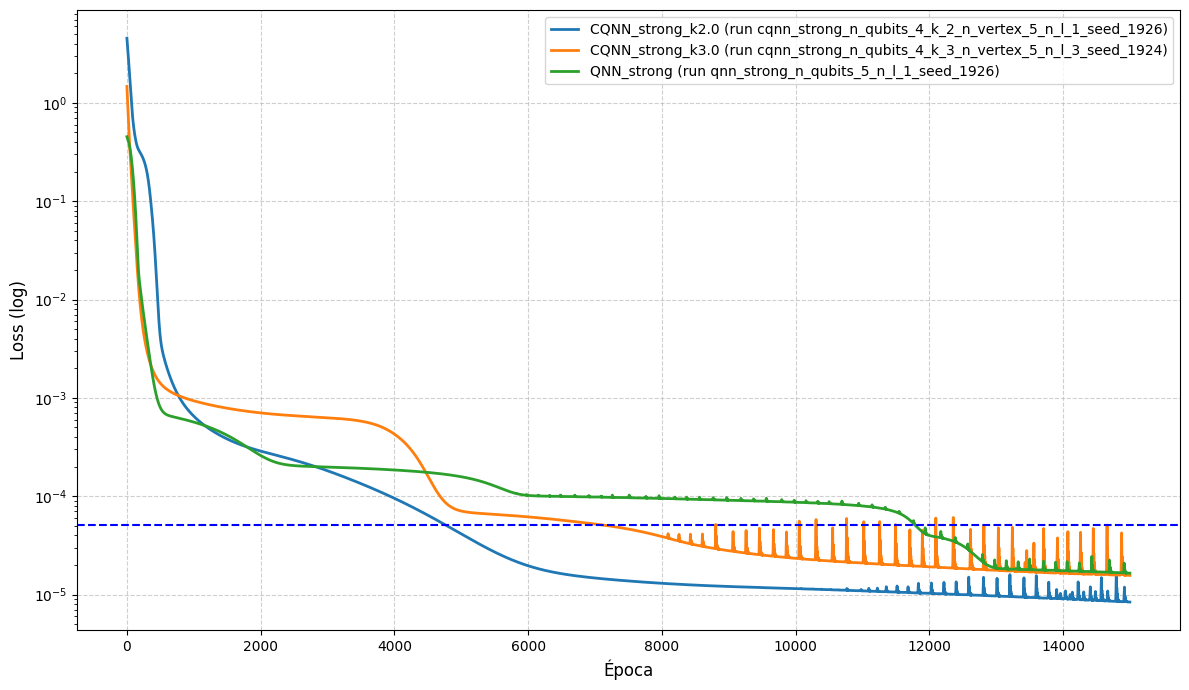

In [ ]:
# =========================
# Melhor run por método + plot do histórico
# =========================

METRIC = 'mean_last_100_loss'   # troque para 'mean_last_100_loss' se preferir
HISTORY_KEY = 'Total'                 # ajuste se seu JSON usar outra chave

melhores = []

for metodo in sorted(df_sel['method_k'].unique()):
    df_m = df_sel[df_sel['method_k'] == metodo]
    if df_m.empty or METRIC not in df_m.columns:
        continue
    # escolhe índice do melhor (menor métrica)
    idx_best = df_m[METRIC].idxmin()
    best_row = df_sel.loc[idx_best]
    melhores.append(best_row)

# imprime um resumo rápido
print("Melhores por método (ordenado):")
for r in melhores:
    print(f"- {r['method_k']}: run_id={r['run_id']}  {METRIC}={r[METRIC]:.6g}")

# plota histórico de cada melhor método
plt.figure(figsize=(12, 7))
for r in melhores:
    hist = load_loss_history(r['loss_history_path'])
    if not hist:
        print(f"AVISO: sem histórico para {r['method_k']} -> {r['loss_history_path']}")
        continue
    if HISTORY_KEY not in hist:
        # tenta chaves alternativas comuns
        key_alt = next((k for k in hist.keys() if k.lower() in ['total','loss','train','train_total']), None)
        if key_alt is None:
            print(f"AVISO: chave '{HISTORY_KEY}' não encontrada no histórico de {r['method_k']}.")
            continue
        serie = hist[key_alt]
    else:
        serie = hist[HISTORY_KEY]

    plt.plot(serie, label=f"{r['method_k']} (run {r['run_id']})", linewidth=2),


plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.yscale('log')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss (log)', fontsize=12)
plt.grid(True, ls='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
